# Calculating sea ice area and extent

> Updated August 2023 <br/>

## Background
The sea ice cover is one of the key components of the polar ecological and climatological research. This measurement has gained attention because of the recent decrease in the Arctic sea ice cover. Satellite observations are a key tool in tracking sea ice cover, providing continuous global coverage extending back to 1978. Typically, sea ice cover is reported as sea ice concentration, which is the percent areal coverage of ice within a grid cell. Depending on the application, additional parameters of interest can be calculated from sea ice cover:  
* __Sea ice area__ - the sum of the product of ice concentration and area of all grid cells with at least 15% ice concentration.  
* __Sea ice extent__ - the sum of the areas of all grid cells with at least 15% ice concentration

## Objective
This tutorial will demonstration how to calculate the sea ice area and extent using sea ice concentration and grid cell area data.  Please visit the  <a href="https://nsidc.org/learn/ask-scientist/what-difference-between-sea-ice-area-and-extent#:~:text=But%20NSIDC%20scientists%2C%20like%20most,the%20total%20in%20their%20entirety.&text=Calculating%20sea%20ice%20extent%20means,with%2015%20percent%20or%20more.">NSIDC website</a> for more detailed descriptions of the calculations. 

## The tutorial demonstrates the following techniques
-   Downloading and saving a netcdf file from PolarWatch ERDDAP data server
-   Accessing satellite data and metadata in polar stereographic projection
-   Downloading and adding grid cell area data to the satellite data
-   Visualizing data on a map
-   Computing sea ice area and extent using sea ice concentration data
-   Plotting a time series of sea ice area and extent

## Datasets used

__Sea Ice Concentration, NOAA/NSIDC Climate Data Record V4, Northern Hemisphere__   
The Sea ice concentration (SIC) dataset used in this exercise is produced by NOAA NSIDC from passive microwave sensors at part of the Climate Data Record. It is a science quality dataset of monthly averages the extends from 1978-2022. SIC is reported as the fraction (0 to 1) of each grid cell that is covered by ice. The data are mapped in the Northern Polar Stereographic projection (EPSG:3413). The resolution is 25km, meaning each grid in this data set represents a value that covers a 25km by 25km area. The dataset is available on the <a href="https://polarwatch.noaa.gov/catalog/ice-sq-nh-nsidc-cdr-v4/preview/?dataset=monthly&var=cdr_seaice_conc_monthly&time_min=2022-12-01T00:00:00Z&time_max=2022-12-01T00:00:00Z&proj=epsg3413&colorBar=KT_ice,,,0,1,">PolarWatch data portal</a> and can be  downloaded directly from the PolarWatch ERDDAP at the following link: https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.graph

__Polar Stereographic Ancillary Grid Information__   
This dataset includes area values (m<sup>2</sup>) of each grid cell in the 25km resolution Northern Polar Stereographic projection (EPSG:3413). The file for this exercise is available in the <a href="#">resources folder</a> or can be downloaded from the NSIDC website at https://nsidc.org/data/nsidc-0771/versions/1.



### Import packages

In [1]:
import urllib.request
import xarray as xr    
import numpy as np
import pyproj  
from pyproj import CRS
from pyproj import Transformer as transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl

## Download the Arctic Sea Ice Concentration Data
### Review of the ERDDAP data request URL
For our first exercise, we will download sea ice concentration data that has been temporally subsetted:
* A single month, December 2021  

and spatially subsetted:
* Y grid values that have been subsetted from the full range (5337500m to -5337500m) to a reduced range (4843696m to -4858210m). 

__The ERDDAP data request URL for this data subset is presented below.__ 

```
https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.nc?cdr_seaice_conc_monthly[(2021-01-01T00:00:00Z):1:(2021-12-01T00:00:00Z)][(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]"
```

__The following table shows the component parts of the ERDDAP data request URL.__  

| Name   | Value| Description |
| ---:        |    :----   |          :--- |
| **base_url**    |    https://polarwatch.noaa.gov/erddap/griddap  | ERDDAP URL for gridded datasets
| **datasetID** | nsidcG02202v4nhmday   | Unique ID for dataset from PolarWatch ERDDAP
| **file_type**  | .nc        | format of file to download (netCDF) |
| **query_start**   | ?        | Details of the query follow the ?  
| **variable_name**   | cdr_seaice_conc_monthly        | Variable from the dataset 
| **date_range**   | **[(2021-01-01T00:00:00Z):1:(2021-01-01T00:00:00Z)]**      |  Temporal range (2021-01-01)
| **spatial_range**   | [**(4843696.04):1:(-4858210.64)**][(-3850000.0):1:(3750000.0)]  |  Y and X axes ranges 

 



### Generate the ERDDAP data query URL from its component parts

In [2]:
base_url = 'https://polarwatch.noaa.gov/erddap/griddap/'
datasetID = 'nsidcG02202v4nhmday'
file_type = '.nc'
query_start = '?'
variable_name = 'cdr_seaice_conc_monthly'
date_range = '[(2021-01-01T00:00:00Z):1:(2021-01-01T00:00:00Z)]'
spatial_range = '[(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]'

#url_start = ''.join([base_url, datasetID, file_type])

url = ''.join([base_url,
               datasetID,
               file_type,
               query_start,
               variable_name,
               date_range,
               spatial_range
               ])
url

'https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.nc?cdr_seaice_conc_monthly[(2021-01-01T00:00:00Z):1:(2021-01-01T00:00:00Z)][(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]'

### Download the data and load into Python

In [3]:
# Download the data from ERDDAP URL as a netCDF file
urllib.request.urlretrieve(url, "sic.nc")

# Open the netCDF file to create an xarray dataset object
ds = xr.open_dataset("sic.nc")
ds

<xarray.Dataset>
Dimensions:                  (time: 1, ygrid: 389, xgrid: 304)
Coordinates:
  * time                     (time) datetime64[ns] 2021-01-01
  * ygrid                    (ygrid) float32 4.838e+06 4.812e+06 ... -4.862e+06
  * xgrid                    (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
Data variables:
    cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 ...
Attributes: (12/65)
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc_monthly
    comment:                                             The variable melt_on...
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1M
    time_coverage_end:                                   2021-01-01T00:00:00Z
    time_coverage_resolution:                            P1M
    time_coverage_start:                                 2021-01-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

### Display the sea ice cover data as a map
The sea ice concentration values range from zero (no ice cover) to 1 (100% ice cover). However, this dataset also includes values above 1 to flag features like lakes, coastline, and land. Therefore, included in the code below is a step to remove those flag values from the mapping work flow.

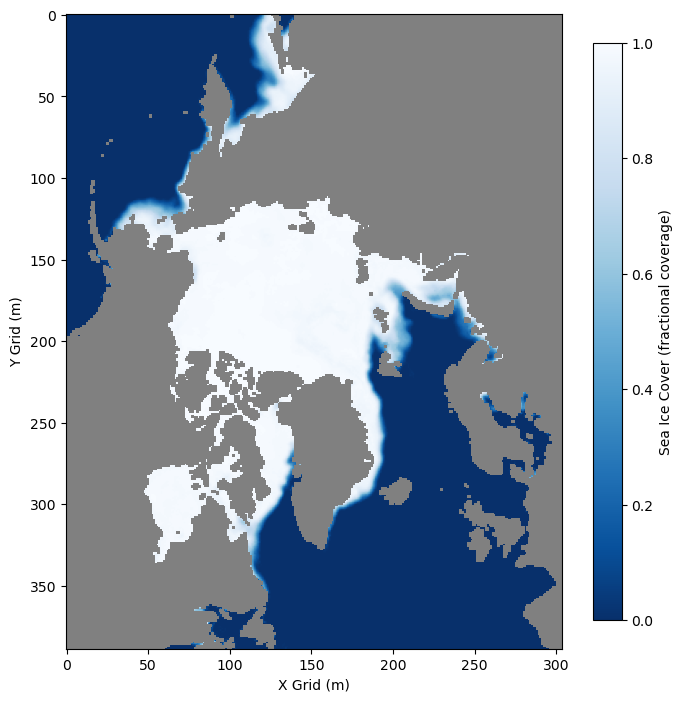

In [5]:
img = ds['cdr_seaice_conc_monthly'].squeeze()

# Remove flag values
img = img.where(img <= 1)
  
# Make plot area
fig, ax = plt.subplots(figsize=(8, 10))

# Set the color palette
cmap = mpl.cm.get_cmap("Blues_r").copy()
cmap.set_bad(color='gray')

# show image
shw = ax.imshow(img, cmap=cmap, vmin=0, vmax=1)
 
# Make the colorbar
bar = plt.colorbar(shw, shrink=0.75)
  
# show plot with labels
plt.xlabel('X Grid (m)')
plt.ylabel('Y Grid (m)')
bar.set_label('Sea Ice Cover (fractional coverage)')
plt.show()


## Get area information from the ancillary grid dataset

While the resolution of this data set is 25km (25km by 25km grid), the actual area of the grid depends on the grid projection. To obtain area value, we will need to:  
* Subset the Polar Stereographic Ancillary Grid Information dataset to match our SIC dataset and 
* Extract the area values for each grid cell. 


In [6]:
# Open the netCDF file to create an Xarray dataset object for the grid data
# grid_area = xr.open_dataset("../resources/NSIDC0771_CellArea_PS_N25km_v1.0.nc")
grid_area = xr.open_dataset("NSIDC0771_CellArea_PS_N25km_v1.0.nc")

# Subset grid area to match SIC data grids
sub_area = grid_area.sel(x=slice(ds['xgrid'].min(), ds['xgrid'].max()),
                         y=slice(ds['ygrid'].max(), ds['ygrid'].min())
                         )
sub_area

<xarray.Dataset>
Dimensions:    (x: 304, y: 389)
Coordinates:
  * x          (x) float64 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y          (y) float64 4.838e+06 4.812e+06 ... -4.838e+06 -4.862e+06
Data variables:
    crs        int32 ...
    cell_area  (y, x) float64 ...
Attributes: (12/38)
    title:                     Polar Stereo Ancillary Grid Information
    summary:                   This data set provides the total on-Earth surf...
    id:                        10.5067/N6INPBT8Y104
    metadata_link:             https://doi.org/10.5067/N6INPBT8Y104
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced and supported by the N...
    ...                        ...
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           1.0

### Combine the subsetted grid to the SIC dataset
Add subsetted area values from grid_area dataset as a new layer in the sea ice concentration dataset.

In [7]:
# Add agrid area to the dataset
#cell_area = sub_area.cell_area.values
ds['area'] = (('ygrid', 'xgrid'), sub_area.cell_area.values)
ds

<xarray.Dataset>
Dimensions:                  (time: 1, ygrid: 389, xgrid: 304)
Coordinates:
  * time                     (time) datetime64[ns] 2021-01-01
  * ygrid                    (ygrid) float32 4.838e+06 4.812e+06 ... -4.862e+06
  * xgrid                    (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
Data variables:
    cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 ...
    area                     (ygrid, xgrid) float64 4.266e+08 ... 4.289e+08
Attributes: (12/65)
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc_monthly
    comment:                                             The variable melt_on...
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1M
    time_coverage_end:                                   2021-01-01T00:00:00Z
    time_coverage_resolution:                            P1M
    time_coverage_start:                                 2021-01-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

## Compute Sea ice area and extent
Although area and extent may sound the same, they are different measurements. 
* Sea ice area is the total region covered by ice, i.e. area that is 100% covered by ice. 
* Sea ice extent is the total region with at least 15 percent sea ice cover. 

Therefore, extent will give higher values than area.



In [8]:
# Subset the dataset to exclude flag values (value > 1)
seaice_ds = ds.where(ds.cdr_seaice_conc_monthly <= 1)

# Set all cell with < 15% ice cover to zero
# Leave the other cells unchanged
cells_15ice_andup = xr.where(seaice_ds.cdr_seaice_conc_monthly.squeeze() < 0.15, 
                             0,  # Set to 0
                             seaice_ds.cdr_seaice_conc_monthly.squeeze()   # Set to 1
                             )

# Calculate sea ice area
icearea = seaice_ds.area * cells_15ice_andup 

# Convert the units from m^2 to km^2
icearea_km = np.sum(icearea) / 1000000  
print("Sea Ice Area (km^2): ", icearea_km.item())

# Compute sea ice extent
# Find all cells with < 0.15 ice cover and set to 0, Set all other cells to 1
cells_15ice_andup = xr.where(seaice_ds.cdr_seaice_conc_monthly.squeeze() < 0.15, 
                             0,  # Set to 0
                             1  # Set to 1
                             )

# Calculate sea ice extent
extent = seaice_ds.area * cells_15ice_andup
extent_km = np.sum(extent)/1000000 
print("Sea Ice Extent (km^2):", extent_km.item())

Sea Ice Area (km^2):  12528341.191722928
Sea Ice Extent (km^2): 13808725.557170859


## Create a time series with 12 months of data

#### For the next exercise, download 12 months of SIC data from 2021. Then, compute sea ice area and extent for each month and plot the time series. 

The first step is to change our ERDDAP data query URL to request the 12 month time period. To do this, change the second part of the __Time coverage__ component of the URL December of 2021 (see the table below). 

| Name   | Value| Description |
| ---:        |    :----   |          :--- |
| **base_url**    |    https://polarwatch.noaa.gov/erddap/griddap  | ERDDAP URL for gridded datasets
| **datasetID** | nsidcG02202v4nhmday   | Unique ID for dataset from PolarWatch ERDDAP
| **file_type**  | .nc        | NetCDF and there are many other available file formats|
| **query_start**   | ?        | Details of the query follow the ?  
| **variable_name**   | cdr_seaice_conc_monthly        | Variables from the dataset 
| **date_range**   | __[(2021-01-01T00:00:00Z):1:(2021-12-01T00:00:00Z)]__      |  Temporal range
| **spatial_range**   | [(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]  |  Spatial range 

__The modified ERDDAP data request URL for this data subset is presented below:__

<code>url="https:\/\/polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.nc?cdr_seaice_conc_monthly[(**2021-01-01T00:00:00Z**):1:( **2021-12-01T00:00:00Z** )][(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]</code>

__We can generate the URL quickly changing the "date_range" variable__  
* From: `date_range = '[(2021-01-01T00:00:00Z):1:(2021-01-01T00:00:00Z)]'`    
* To: `date_range = '[(2021-01-01T00:00:00Z):1:(2021-12-01T00:00:00Z)]'`

__Then rerunning the code to generate the ERDDAP data query URL.__

In [9]:
date_range = '[(2021-01-01T00:00:00Z):1:(2021-12-01T00:00:00Z)]'

#url_start = base_url + datasetID + file_type

url = ''.join([base_url,
               datasetID,
               file_type,
               query_start,
               variable_name,
               date_range,
               spatial_range
               ])
url

'https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.nc?cdr_seaice_conc_monthly[(2021-01-01T00:00:00Z):1:(2021-12-01T00:00:00Z)][(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]'

### Generate the sea ice area and extent time series

In [10]:
# Download 12 months of data
urllib.request.urlretrieve(url, "sic12.nc")

# Open the netCDF file to create an Xarray dataset object
ds = xr.open_dataset("sic12.nc")

# Add grid area to the dataset
cell_area = sub_area.cell_area.values
ds['area'] = (('ygrid', 'xgrid'), cell_area)

# Subset the dataset to exclude flag values
seaice_ds = ds.where(ds.cdr_seaice_conc_monthly <= 1)

# Find all cells with < 0.15 ice cover and set to 0.
# Leave the other cells unchanged
cells_15ice_andup_ts = xr.where(seaice_ds.cdr_seaice_conc_monthly < 0.15, 
                             0,  # Set to 0
                             seaice_ds.cdr_seaice_conc_monthly
                             )

# Calculate sea ice area for each time layer
icearea_timeseries = seaice_ds.area * cells_15ice_andup_ts

# Sum area for each time step and convert to km^2
icearea_timeseries_km = icearea_timeseries.sum(dim=['xgrid', 'ygrid']) / 1000000

# Find all cells with < 0.15 ice cover and set to 0. Set all other cells to 1
cells_15ice_andup_ts = xr.where(seaice_ds.cdr_seaice_conc_monthly < 0.15,
                                0,  # Set to 0
                                1  # Set to 1
                                )

# Calculate sea ice extent by month
extent_timeseries = seaice_ds.area * cells_15ice_andup_ts

# # Sum extent for each time step and convert units to km^2
extent_timeseries_km = extent_timeseries.sum(dim=['xgrid', 'ygrid']) / 1000000

### Plot the sea ice area and extent time series

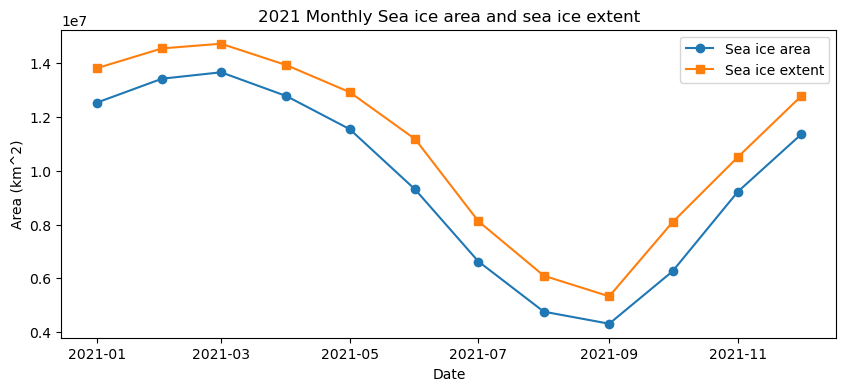

In [11]:

fig, ax = plt.subplots(figsize=(10, 4))

# Plot the data as a line
ax.plot(icearea_timeseries_km.time, 
        icearea_timeseries_km,
        label='Sea ice area',
        marker='o', 
        linestyle='-')

ax.plot(extent_timeseries_km.time,
        extent_timeseries_km,
        label='Sea ice extent',
        marker='s', 
        linestyle='-')

# Add a title and labelsa
ax.set_title('2021 Monthly Sea ice area and sea ice extent')
ax.set_xlabel('Date')
ax.set_ylabel('Area (km^2)')

# Display the legend
ax.legend()

# Show the plot
plt.show()

## References
-   <a href="https://nsidc.org/data/g02202/versions/4" target="_blank">NSIDC Data Product Description</a>
-   <a href="https://nsidc.org/sites/default/files/g02202-v004-userguide_1_1.pdf" target="_blank">NSIDC Data Product User Guide (pdf)</a>
- <a href="https://polarwatch.noaa.gov/catalog/">PolarWatch Data Catalog</a>
- <a href="https://nsidc.org/learn/ask-scientist/what-difference-between-sea-ice-area-and-extent#:~:text=But%20NSIDC%20scientists%2C%20like%20most,the%20total%20in%20their%20entirety.&text=Calculating%20sea%20ice%20extent%20means,with%2015%20percent%20or%20more.">What's the difference between Sea ice area and extent?</a>
- <a href="https://nsidc.org/arcticseaicenews/">NSIDC Arctic Sea Ice News & Analysis</a>
- <a href="https://www.climate.gov/news-features/understanding-climate/understanding-climate-antarctic-sea-ice-extent">Climate.gov Understanding Climate: sea ice extent</a>
* The several CoastWatch Node websites have data catalog containing documentation and links to all the datasets available:  
    * https://oceanwatch.pifsc.noaa.gov/doc.html
    * https://coastwatch.pfeg.noaa.gov/data.html
